# Exercise 3: Reusing Pre-trained LLMs (choose one)

Choose **one** of the following exercises (well, *at least* one). In each of these you are asked to adapt a pre-trained LLM (`GPT2Model` or `DistillBERT` are two good choices) to a new Natural Language Understanding task. A few comments:

+ Since GPT2 is a *autoregressive* model, there is no latent space aggregation at the last transformer layer (you get the same number of tokens out that you give in input). To use a pre-trained model for a classification or retrieval task, you should aggregate these tokens somehow (or opportunistically select *one* to use).

+ BERT models (including DistillBERT) have a special [CLS] token prepended to each latent representation in output from a self-attention block. You can directly use this as a representation for classification (or retrieval).

+ The first *two* exercises below can probably be done *without* any fine-tuning -- that is, just training a shallow MLP to classify or represent with the appropriate loss function.

# Exercise 3.1: Training a Text Classifier (easy)

Peruse the [text classification datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=downloads). Choose a *moderately* sized dataset and use a LLM to train a classifier to solve the problem.

**Note**: A good first baseline for this problem is certainly to use an LLM *exclusively* as a feature extractor and then train a shallow model.

# Exercise 3.2: Training a Question Answering Model (harder)

Peruse the [multiple choice question answering datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:multiple-choice&sort=downloads). Chose a *moderately* sized one and train a model to answer contextualized multiple-choice questions. You *might* be able to avoid fine-tuning by training a simple model to *rank* the multiple choices (see margin ranking loss in Pytorch).

# Exercise 3.3: Training a Retrieval Model (hardest)

The Hugging Face dataset repository contains a large number of ["text retrieval" problems](https://huggingface.co/datasets?task_categories=task_categories:text-retrieval&p=1&sort=downloads). These tasks generally require that the model measure *similarity* between text in some metric space -- naively, just a cosine similarity between [CLS] tokens can get you pretty far. Find an interesting retrieval problem and train a model (starting from a pre-trained LLM of course) to solve it.

**Tip**: Sometimes identifying the *retrieval* problems in these datasets can be half the challenge. [This dataset](https://huggingface.co/datasets/BeIR/scifact) might be a good starting point.

# Exercise 3.1: Training a Text Classifier

In [1]:
from transformers import DistilBertModel, AutoTokenizer, DataCollatorWithPadding

import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import wandb
import os
from tqdm import tqdm
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt
from functools import reduce
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import wandb
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime
import re

torch.cuda.is_available()

True

In [2]:
# REWRITE TRAINING AND EVALUATION FUNCTIONS 
# Function to train one epoch
def train_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        opt: optim.Optimizer, 
        device="cuda"
    ):

    model.train()

    losses = []
    gts = []
    preds = []

    # Zero out the gradients
    opt.zero_grad()
    
    for (i, (batch)) in enumerate(tqdm(data, desc=f"Training epoch {epoch}", leave=True)):
        # Get the input and target data and move it to the device
        xs = batch["input_ids"].to(device)
        ms = batch["attention_mask"].to(device)
        ys = batch["labels"].to(device)

        # Zero out the gradients
        opt.zero_grad()

        # Forward pass
        logits = model(xs, ms)

        # Get the predicted classes
        pred = torch.argmax(logits, 1)
        
        # Compute the cross entropy loss
        loss = F.cross_entropy(logits, ys)

        # Backward pass
        loss.backward()

        # Update the model parameters
        opt.step()

        # Append the loss
        losses.append(loss.item())
        preds.extend(pred.detach().cpu().numpy())
        gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)
    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()

    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
       report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "train/epoch": epoch, 
        "train/loss": loss, 
        "train/accuracy": accuracy, 
        "train_class_rep/classification_report": class_report,
        "train/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "train/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        },
        step=epoch)

    # Return the average loss, accuracy and classification report
    return loss, accuracy, class_report

# Function to evaluate one epoch
def evaluate_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        device="cuda"
    ):

    model.eval()

    losses = []
    preds = []
    gts = []
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for (_, (batch)) in enumerate(tqdm(data, desc=f"Evaluating", leave=True)):
            # Get the input and target data and move it to the device
            xs = batch["input_ids"].to(device)
            ms = batch["attention_mask"].to(device)
            ys = batch["labels"].to(device)

            # Forward pass
            logits = model(xs, ms)

            # Compute the cross entropy loss
            loss = F.cross_entropy(logits, ys)

            # Get the predicted classes
            pred = torch.argmax(logits, 1)

            # Append the loss, predictions and ground truths
            losses.append(loss.item())
            preds.extend(pred.detach().cpu().numpy())
            gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)

    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()
    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
        report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "val/epoch": epoch, 
        "val/loss": loss, 
        "val/accuracy": accuracy,
        "val_class_rep/classification_report": class_report,
        "val/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "val/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        }, 
        step=epoch)
    
    return loss, accuracy, class_report

# Function to train and evaluate the model
def train_evaluate_model(
        model: nn.Module, 
        model_name: str,
        dataset_name: str,
        class_names: list,
        dl_train: DataLoader, 
        dl_test: DataLoader, 
        batch_size: int, 
        lr: int, 
        epochs: int, 
        opt: optim.Optimizer, 
        device="cuda",
    ):

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    test_name = model_name+"-"+time+"_"+dataset_name+"_epochs-"+str(epochs)+"_bs-"+str(batch_size)+"_lr-"+str(lr)

    wandb_init(model_name, test_name, model, dataset_name, epochs, batch_size, lr, device)

    # Train and evaluate the model
    train_results = {"loss": [], "acc": [], "class_rep": []}
    val_results = {"loss": [], "acc": [], "class_rep": []}
    max_val_acc = 0
    state_dict = None

    for epoch in range(epochs):
        # Train the model 
        train_loss, train_acc, train_class_rep = train_epoch(model, dl_train, class_names, epoch, opt, device=device)

        # Evaluate the model
        val_loss, val_acc, val_class_rep = evaluate_epoch(model, dl_test, class_names, epoch, device=device)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            state_dict = model.state_dict()
        
        # Append the results
        train_results["loss"].append(train_loss)
        train_results["acc"].append(train_acc)
        train_results["class_rep"].append(train_class_rep)
        val_results["loss"].append(val_loss)
        val_results["acc"].append(val_acc)
        val_results["class_rep"].append(val_class_rep)

    wandb.unwatch(model)
    wandb.finish()

    plot_validation_curves(train_results["loss"], val_results["loss"], train_results["acc"], val_results["acc"])

    model_states_path = "model_states/"+test_name+".pth"

    # Save the best model
    if state_dict is not None:
        torch.save(state_dict, model_states_path)
        print(f"Model saved to {model_states_path}")

# Function to initialize wandb
def wandb_init(
        model_name, 
        test_name, 
        model, 
        dataset, 
        epochs, 
        bs, 
        lr, 
        device, 
        project="DLA Assigment 2"
    ):
    # Initialize wandb
    wandb.init(
        project=project,
        name=test_name,
        # Track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset,
            "epochs": epochs,
            "batch_size": bs,
            "lr": lr,
            "optimizer": "Adam",
            "device": device.type
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss(), log="all")

# Simple function to plot the loss curve and accuracy.
def plot_validation_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title(f'Best Validation Accuracy = {np.max(val_acc)} @ epoch {np.argmax(val_acc)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [3]:
class BERTClassifier(nn.Module):
    def __init__(self, model, n_classes):
        super().__init__()
        self.model = model
        self.classifier = nn.Sequential(
            nn.Linear(model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, n_classes)
        )

    def forward(self, x, mask):
        x = self.model(x, attention_mask=mask).last_hidden_state[:, 0]
        return self.classifier(x)

In [ ]:
datasets = load_dataset("tweet_eval", "emoji")
datasets.save_to_disk("../data/tweet_emoji")

In [6]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length, val_data = None, dataset_limit = None, normalize = False):
        self.texts = data["text"]
        self.labels = data["label"]
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.normalize = normalize
        if val_data is not None:
            # Add validation data
            self.texts.extend(val_data["text"])
            self.labels.extend(val_data["label"])
        if dataset_limit is not None:
            # Choose a random subset of the data
            print(f"Limiting dataset to {dataset_limit} samples")
            print(f"Original dataset size: {len(self.texts)}")
            idxs = np.random.choice(len(self.texts), dataset_limit, replace=False)
            self.texts = [self.texts[i] for i in idxs]
            self.labels = [self.labels[i] for i in idxs]
        
    def __len__(self):
        return len(self.texts)
    
    def format_text(self, text):
        # lowercase
        text = text.lower()
        # remove user tags
        text = re.sub(r'@\w', '', text)
        # Remove double spaces
        text = re.sub(r'\s+', ' ', text)
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove hashtags
        text = re.sub(r'#', '', text)
        return text

    def __getitem__(self, idx):
        if self.normalize:
            text = self.format_text(self.texts[idx])
        else:
            text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label)
        }

In [ ]:
""" 
TOO BIG AND SLOW 

The best results for the emoji dataset with Bert is about 33% accuracy, which is not good enough.
"""
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32

# Dataset
dataset = load_from_disk("../data/Tweet_emoji")
classes_names = ["❤️","😍","😂","💕","🔥","😊","😎","✨", "💙","😘","📷","🇺🇸","☀","💜","😉","💯","😁","🎄","📸","😜"]
n_classes = len(classes_names)

max_length = 128
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

ds_train = TweetDataset(dataset['train'], tokenizer, max_length=max_length, val_data=dataset['validation'])
ds_val = TweetDataset(dataset['test'], tokenizer, max_length=max_length)

data_collator = DataCollatorWithPadding(tokenizer)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

# Instantiate the model
model = BERTClassifier(DistilBertModel.from_pretrained('distilbert-base-uncased'), n_classes).to(device)

# Train the model
epochs = 5
lr = 2e-5
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=lr)

# Train the model
train_evaluate_model(
    model=model, 
    model_name="DistilBERTClassifier", 
    dataset_name="emoji", 
    class_names=classes_names,
    dl_train=dl_train,
    dl_test=dl_val,
    batch_size=batch_size, 
    lr=lr,
    epochs=epochs, 
    opt=opt,
    device=device
)

In [10]:
datasets = load_dataset("tweet_eval", "irony")
datasets.save_to_disk("../data/tweet_irony")

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2862 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/784 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/955 [00:00<?, ? examples/s]

c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


Evaluating: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch 0: Train Loss: 0.6310, Train Acc: 0.6324, Val Loss: 0.6083, Val Acc: 0.6645


Evaluating: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


Epoch 1: Train Loss: 0.5023, Train Acc: 0.7514, Val Loss: 0.6632, Val Acc: 0.6633


Evaluating: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch 2: Train Loss: 0.3132, Train Acc: 0.8680, Val Loss: 0.6731, Val Acc: 0.7156


Evaluating: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch 3: Train Loss: 0.1501, Train Acc: 0.9463, Val Loss: 0.9961, Val Acc: 0.6645


Evaluating: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch 4: Train Loss: 0.0654, Train Acc: 0.9796, Val Loss: 1.1557, Val Acc: 0.6977


train/accuracy,▁▃▆▇█
train/epoch,▁▃▅▆█
train/loss,█▆▄▂▁
val/accuracy,▁▁█▁▆
val/epoch,▁▃▅▆█
val/loss,▁▂▂▆█
train/accuracy,0.97957
train/epoch,4
train/loss,0.06538
val/accuracy,0.6977
val/epoch,4


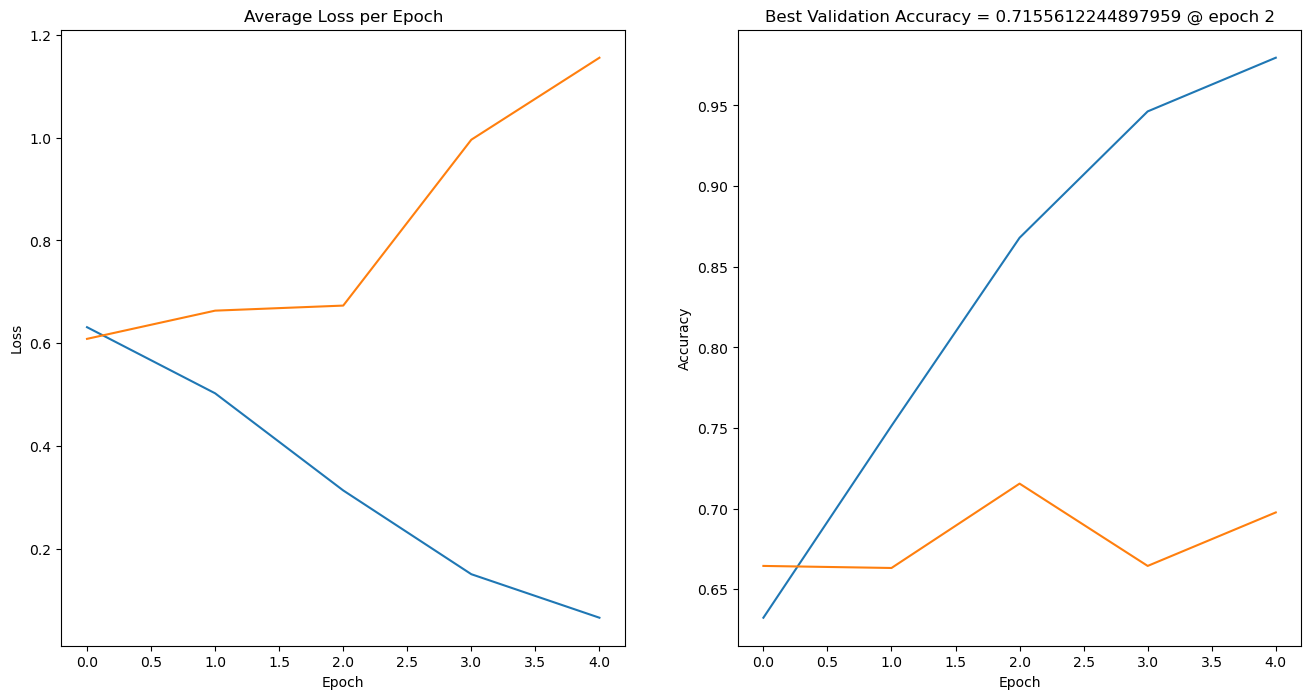

Model saved to model_states/DistilBERTClassifier-2024-07-08_18-06-34_tweet_irony_epochs-5_bs-16_lr-2e-05.pth


In [7]:
"""
We try to use a smaller dataset to see if we can get better results.

The best results for the irony dataset with Bert is about 80% accuracy.
"""

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16

# Dataset
dataset = load_from_disk("../data/tweet_irony")
classes_names = ["non_irony", "irony"]
n_classes = len(classes_names)

max_length = 280
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

ds_train = TweetDataset(dataset['train'], tokenizer, max_length=max_length, val_data=dataset['validation'])
ds_val = TweetDataset(dataset['test'], tokenizer, max_length=max_length)

data_collator = DataCollatorWithPadding(tokenizer)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

# Instantiate the model
model = BERTClassifier(DistilBertModel.from_pretrained('distilbert-base-uncased'), n_classes).to(device)

# Train the model
epochs = 5
lr = 2e-5
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=lr)

# Train the model
train_evaluate_model(
    model=model, 
    model_name="DistilBERTClassifier", 
    dataset_name="tweet_irony", 
    class_names=classes_names,
    dl_train=dl_train,
    dl_test=dl_val,
    batch_size=batch_size, 
    lr=lr,
    epochs=epochs, 
    opt=opt,
    device=device
)

# Exercise 3.2: Training a Question Answering Model

In [ ]:
squad = load_dataset("squad", split="train[:10000]")
squad.save_to_disk("../data/squad")

In [ ]:
# Load the dataset
dataset = load_from_disk("../data/squad")
# Split the dataset into training and validation
train_dataset = dataset["train"].select(range(8000))
val_dataset = dataset["train"].select(range(8000, 10000))

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length = 384):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = data.map(self.preprocess_function, batched=True)

    def preprocess_function(self, data):
        questions = [q.strip() for q in data["question"]]
        inputs = tokenizer(
            questions,
            data["context"],
            max_length=self.max_length,
            truncation="only_second",
            return_offsets_mapping=True,
            padding="max_length",
        )

        offset_mapping = inputs.pop("offset_mapping")
        answers = data["answers"]
        start_positions = []
        end_positions = []

        for i, offset in enumerate(offset_mapping):
            answer = answers[i]
            start_char = answer["answer_start"][0]
            end_char = answer["answer_start"][0] + len(answer["text"][0])
            sequence_ids = inputs.sequence_ids(i)

            # Find the start and end of the context
            idx = 0
            while sequence_ids[idx] != 1:
                idx += 1
            context_start = idx
            while sequence_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            # If the answer is not fully inside the context, label it (0, 0)
            if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
                start_positions.append(0)
                end_positions.append(0)
            else:
                # Otherwise it's the start and end token positions
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)

        inputs["start_positions"] = start_positions
        inputs["end_positions"] = end_positions
        return inputs  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        self.data[idx]
        

In [ ]:
class BERTQA(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.qa_outputs = nn.Linear(model.config.hidden_size, 1)

    def forward(self, x, mask):
        x = self.model(x, attention_mask=mask).last_hidden_state
        bs = x.size(0)
        
        return self.qa_outputs(x)